In [1]:
import pandas as pd
import numpy as np
from pandas.tseries.offsets import MonthEnd,QuarterEnd

In [2]:
df = pd.read_csv('./Data/pp-complete-28022023.csv',names=['Trans_id', 'price', 'date', 'postcode', 'Property', 'Age','Duration',
                            'PAON', 'SOAN', 'Street', 'Locality', 'Town', 'District', 'County',
                            'PPD', 'Rec_Status'])
df.head()

,Trans_id,price,date,postcode,Property,Age,Duration,PAON,SOAN,Street,Locality,Town,District,County,PPD,Rec_Status
0,{A42E2F04-2538-4A25-94C5-49E29C6C8FA8},18500,1995-01-31 00:00,TQ1 1RY,F,N,L,VILLA PARADISO,FLAT 10,HIGHER WARBERRY ROAD,TORQUAY,TORQUAY,TORBAY,TORBAY,A,A
1,{1BA349E3-2579-40D6-999E-49E2A25D2284},73450,1995-10-09 00:00,L26 7XJ,D,Y,F,6,NaN,CATKIN ROAD,LIVERPOOL,LIVERPOOL,KNOWSLEY,MERSEYSIDE,A,A
2,{E5B50DCB-BC7A-4E54-B167-49E2A6B4148B},59000,1995-03-31 00:00,BH12 2AE,D,N,F,28,NaN,ALDER ROAD,POOLE,POOLE,POOLE,POOLE,A,A
3,{81E50116-D675-4B7F-9F8D-49E2B5D43271},31000,1995-12-04 00:00,IP13 0DR,D,Y,F,NONSUCH COTTAGE,NaN,THE STREET,HACHESTON,WOODBRIDGE,SUFFOLK COASTAL,SUFFOLK,A,A
4,{B97455B9-75CB-40BB-A615-42C53683E143},95000,1995-09-22 00:00,WS14 0BE,D,N,F,FOX COVER COTTAGE,NaN,HALL LANE,LICHFIELD,LICHFIELD,LICHFIELD,STAFFORDSHIRE,A,A


In [25]:
# Converting Date to datetime format
df['transaction_date'] = pd.to_datetime(df['date'], format='%Y/%m/%d %H:%M')
df['transaction_quarter'] = df.transaction_date + QuarterEnd(0,normalize=True)
df['transaction_quarter_num'] = (df['transaction_quarter']-pd.Timestamp('1995-01-31')).dt.days

df['Postcode'] = df.postcode.replace(" ", "",regex=True).str.upper()
df['Postcode_Dstr'] = df.Postcode.str[:-3]
df['Postcode_Area'] = df.Postcode_Dstr.str.extract('([A-Z]*)', expand=False)
df.head()

,Trans_id,price,date,postcode,Property,Age,Duration,PAON,SOAN,Street,...,District,County,PPD,Rec_Status,transaction_date,transaction_quarter,Postcode,Postcode_Dstr,Postcode_Area,transaction_quarter_num
0,{A42E2F04-2538-4A25-94C5-49E29C6C8FA8},18500,1995-01-31 00:00,TQ1 1RY,F,N,L,VILLA PARADISO,FLAT 10,HIGHER WARBERRY ROAD,...,TORBAY,TORBAY,A,A,1995-01-31,1995-03-31,TQ11RY,TQ1,TQ,59
1,{1BA349E3-2579-40D6-999E-49E2A25D2284},73450,1995-10-09 00:00,L26 7XJ,D,Y,F,6,NaN,CATKIN ROAD,...,KNOWSLEY,MERSEYSIDE,A,A,1995-10-09,1995-12-31,L267XJ,L26,L,334
2,{E5B50DCB-BC7A-4E54-B167-49E2A6B4148B},59000,1995-03-31 00:00,BH12 2AE,D,N,F,28,NaN,ALDER ROAD,...,POOLE,POOLE,A,A,1995-03-31,1995-03-31,BH122AE,BH12,BH,59
3,{81E50116-D675-4B7F-9F8D-49E2B5D43271},31000,1995-12-04 00:00,IP13 0DR,D,Y,F,NONSUCH COTTAGE,NaN,THE STREET,...,SUFFOLK COASTAL,SUFFOLK,A,A,1995-12-04,1995-12-31,IP130DR,IP13,IP,334
4,{B97455B9-75CB-40BB-A615-42C53683E143},95000,1995-09-22 00:00,WS14 0BE,D,N,F,FOX COVER COTTAGE,NaN,HALL LANE,...,LICHFIELD,STAFFORDSHIRE,A,A,1995-09-22,1995-09-30,WS140BE,WS14,WS,242


In [43]:
from sklearn.ensemble import IsolationForest

clf = IsolationForest(max_samples=100, random_state=0,contamination=0.02)
clf.fit(df.sample(10**4,random_state=34)[['transaction_quarter_num','price']])

c:\Users\cemly\anaconda3\envs\tf_env\lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


IsolationForest(contamination=0.01, max_samples=100, random_state=0)

In [44]:
df['outlier'] = clf.predict(df[['transaction_quarter_num','price']])

In [50]:
df['anomaly_score'] =  clf.score_samples(df[['transaction_quarter_num','price']])

<AxesSubplot: >

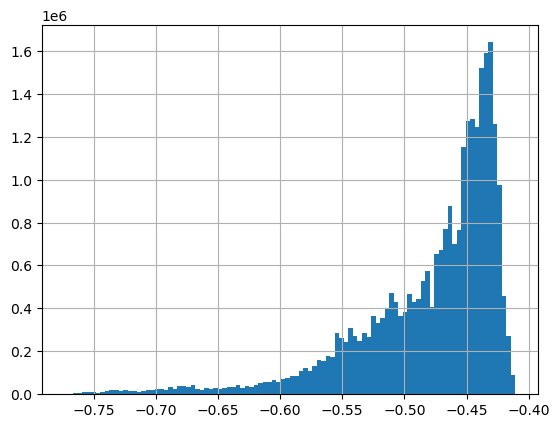

In [51]:
df['anomaly_score'].hist(bins=100)

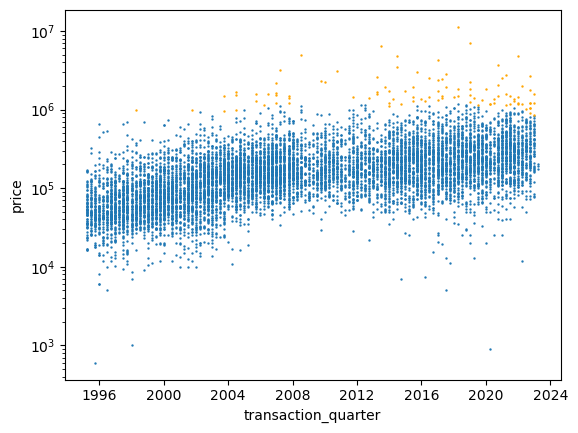

In [55]:
from matplotlib import pyplot as plt
sampled_df = df.sample(10**4,random_state=34)
axes = sampled_df[sampled_df.outlier==1].plot.scatter(x='transaction_quarter',y='price',s=0.5)
sampled_df[sampled_df.outlier!=1].plot.scatter(x='transaction_quarter',y='price',s=0.5,ax=axes,c='orange')
plt.yscale('log')
plt.show()

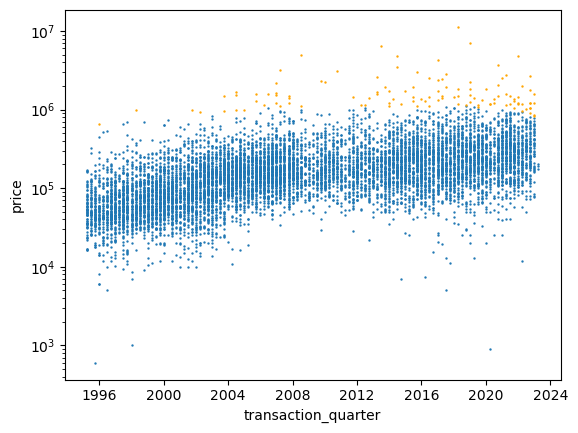

In [62]:
from matplotlib import pyplot as plt
sampled_df = df.sample(10**4,random_state=34)

threshold = 0.69
axes = sampled_df[sampled_df.anomaly_score>-threshold].plot.scatter(x='transaction_quarter',y='price',s=0.5)
sampled_df[sampled_df.anomaly_score<=-threshold].plot.scatter(x='transaction_quarter',y='price',s=0.5,ax=axes,c='orange')
plt.yscale('log')
plt.show()

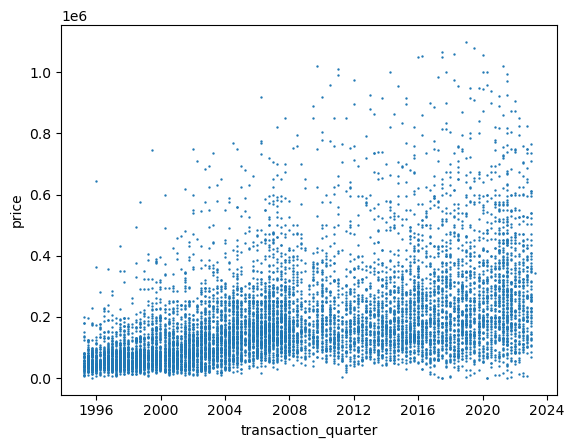

In [63]:
from matplotlib import pyplot as plt
sampled_df = df.sample(10**4)
axes = sampled_df[sampled_df.anomaly_score>-threshold].plot.scatter(x='transaction_quarter',y='price',s=0.5)
#sampled_df[sampled_df.outlier!=1].plot.scatter(x='transaction_quarter',y='price',s=0.5,c='orange',ax=axes)
#plt.yscale('log')
plt.show()

In [64]:
df = df[df.anomaly_score>-threshold]

<AxesSubplot: xlabel='transaction_quarter'>

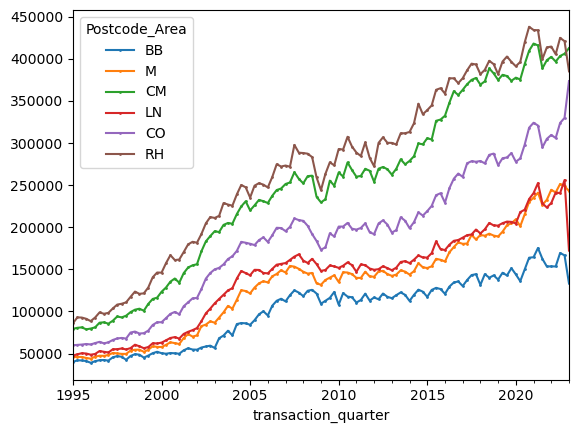

In [65]:
quarter_aggs = df.groupby(['transaction_quarter','Postcode_Area'])['price'].mean().unstack(1)
quarter_aggs.sample(6,axis=1,random_state=34).plot(marker='o',markersize=1.0)

In [66]:
quarter_aggs.shape

(113, 108)

In [67]:
quarter_aggs

Postcode_Area,AL,B,BA,BB,BD,BH,BL,BN,BR,BS,...,W,WA,WC,WD,WF,WN,WR,WS,WV,YO
transaction_quarter,,,,,,,,,,,,,,,,,,,,,
1995-03-31,95746.323750,60409.835279,65703.116605,40080.107961,46690.371570,71081.343082,47932.423490,61686.860265,89868.652132,61453.620295,...,134593.906027,65411.423099,133108.000000,92791.782037,48847.698957,47051.300349,65362.696705,52977.289881,55211.657952,60440.298901
1995-06-30,98414.031313,60107.596869,67798.502664,41928.243845,47841.274851,74031.732692,49883.279631,64250.116022,96632.209398,62466.186911,...,136309.143510,66607.926238,93309.600000,91729.209366,49592.977817,47123.201913,69703.891964,55887.168760,57022.115955,61151.436602
1995-09-30,106365.538938,61739.576003,68259.812829,41759.020319,48365.706361,75151.669605,47350.797840,64280.219439,95016.625000,65749.845580,...,134908.755372,67624.307730,129457.250000,93271.478705,50468.856707,48167.598463,72203.371795,55400.180669,58227.440662,63677.330341
1995-12-31,100814.623094,60535.749692,66201.830327,41081.560193,48142.694931,72226.728159,49285.327737,63782.672767,94159.449367,62101.586400,...,135299.163797,65748.616597,126372.989130,92675.887955,49814.225389,47290.668274,70992.926040,57698.464722,55156.558453,62630.814402
1996-03-31,100899.009901,57113.404973,64878.882917,39009.667087,46085.467562,72526.626332,46005.463476,62637.592481,95217.980036,60897.651689,...,140957.375862,64263.759887,100331.395349,89129.949517,48896.307165,46387.947598,68274.400000,54306.319056,53319.363029,61354.669252
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03-31,479885.935880,250985.476041,327459.076588,153526.213270,172672.360711,358184.200000,196516.411765,372475.581756,472419.154595,336243.116131,...,533309.353008,226360.854248,480220.941176,444028.787062,189994.792069,164625.683348,304389.710669,230492.436726,213001.019828,260845.019723
2022-06-30,465846.370717,255524.165081,325429.341627,153406.971471,183335.936378,361879.930904,204303.315356,372540.579760,469579.813747,338333.172255,...,513904.321513,242750.993122,459312.500000,452342.532331,194263.417722,173197.357709,301752.444882,236955.743092,222376.830540,267323.760259
2022-09-30,479647.033921,270451.839489,342451.526543,169398.520669,191126.524534,373377.085425,207956.756539,395223.739875,487259.632231,354856.121708,...,525854.545050,248468.967639,508446.692308,468482.259362,200589.476775,184979.702560,322455.506206,245389.232092,233758.014423,279233.229373


In [68]:
quarter_aggs_growth = quarter_aggs.pct_change()

In [69]:
corr = quarter_aggs_growth.corr()

In [70]:
corr.to_csv('correlations.csv')

<AxesSubplot: xlabel='transaction_quarter'>

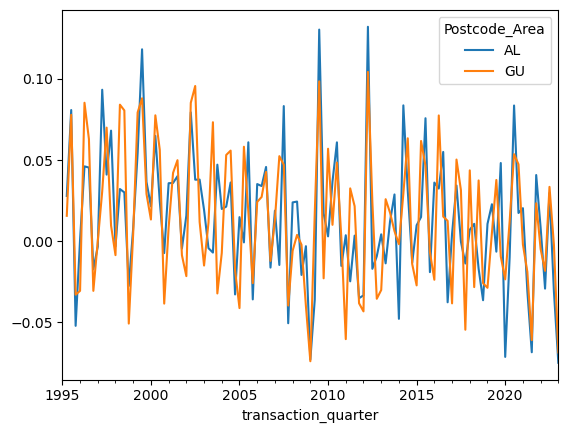

In [71]:
quarter_aggs_growth[['AL','GU']].plot()

In [73]:
import os
quarter_aggs_growth.to_csv(os.path.join(os.getcwd(),'./Data/quarter_aggs_growth.csv'))

Tasks:
- get adjacency matrix (again) - DONE!
- create test train sample and out of time
- see how we prediction goes based on just seasonality and prior quarters performance
- consider adding in some sort of macroeconomics

In [20]:
# Creating the adjacenjy matrix
import shapefile
import itertools
import os
#from haversine import haversine

myshp = open(os.path.join(os.getcwd(),"./Data/shapefiles/Distribution/Areas.shp"), "rb")
mydbf = open(os.path.join(os.getcwd(),"./Data/shapefiles/Distribution/Areas.dbf"), "rb")
myshx= open(os.path.join(os.getcwd(),"./Data/shapefiles/Distribution/Areas.shx"), "rb")

r = shapefile.Reader(shp=myshp, dbf=mydbf, shx=myshx)

In [30]:
r.shapes()[0]

Shape #0: POLYGON

In [21]:
# Getting postcode names
fields = r.records()
fields = [x[0] for x in fields]

# Getting shapes
shapes = r.shapes()

# Compiling into dictionary
data = {keys:values for (keys,values) in zip(fields,shapes)}

In [20]:
from sklearn.metrics.pairwise import haversine_distances
import time

from math import radians, cos, sin, asin, sqrt

def haversine(point1, point2):
    """
    Calculate the great circle distance in kilometers between two points 
    on the earth (specified in decimal degrees)
    """
    assert isinstance(point1,tuple)
    assert isinstance(point2,tuple)

    lon1, lat1 = point1
    lon2, lat2 = point2
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles. Determines return value units.
    return c * r


def Dist_shp(shp1,shp2,sample_fac=20):
    ''' Takes every twentieth element and checks the distance between them'''
    distances = list()
    for a,b in itertools.product(shp1.points[::sample_fac],shp2.points[::sample_fac]):
        distances.append(haversine(a[::-1],b[::-1]))
    
    if len(distances)>0:
        return min(distances)

def adj_dict(code_lst,data,limit,sample_fac=20):
    ''' function to generate postcode adjacency dictionary. '''

    # check which codes don't exist in the dataframe
    

    adj_matrix = np.empty([len(code_lst),len(code_lst)])
    i,j=0,0

    postcode_products = list(itertools.product(code_lst,code_lst))
    length = len(postcode_products)
    
    t0 = time.time()

    for n,x in enumerate(postcode_products):
        
        if (n%100)==0:
            print("Percent:{:0.3%}, Time taken:{}".format(n/length,
                                                          time.strftime('%H:%M:%S', time.gmtime(time.time()-t0))),end="\r", flush=True)
            
        if j>=len(code_lst):
            j=0
            i+=1
            
        if Dist_shp(data[x[0]],data[x[1]],sample_fac=sample_fac)<=limit:
            adj_matrix[i,j] = 1
        else:
            adj_matrix[i,j] = 0
        
        j+=1
    
    return adj_matrix

In [21]:
t0 = time.time()
D_lst = list(quarter_aggs_growth.columns)
D_lst.remove('LR')
D_lst.remove('SU')
D_lst.remove('UNKN')
adj_matrix = adj_dict(D_lst,data,1,sample_fac=5)
#adj_df = pd.DataFrame(adj_matrix,columns=D_lst, index=D_lst)
#adj_df.to_pickle(os.path.join(os.getcwd(),'./Data/adjacency_matrix_1km.csv'))

In [28]:
adj_df = pd.DataFrame(adj_matrix,columns=D_lst, index=D_lst)
adj_df.to_csv(os.path.join(os.getcwd(),'./Data/adjacency_matrix_1km.csv'))

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as pyplot
import networkx as nx
import os

adjanceny_matrix = pd.read_csv(os.path.join(os.getcwd(),'./Data/adjacency_matrix_1km.csv'),index_col=0)
growth_df = pd.read_csv(os.path.join(os.getcwd(),'./Data/quarter_aggs_growth.csv'),parse_dates=['transaction_quarter']).dropna()
growth_df.head()

,transaction_quarter,AL,B,BA,BB,BD,BH,BL,BN,BR,...,W,WA,WC,WD,WF,WN,WR,WS,WV,YO
102,2020-09-30,0.107107,0.173148,0.165638,0.331889,0.046126,0.028049,0.047548,0.034656,0.076705,...,-0.218131,0.127580,0.375451,0.046675,0.234542,-0.397627,-0.335230,-0.450804,-0.030395,0.044286
103,2020-12-31,-0.029527,0.072700,0.016957,-0.047875,0.051418,-0.004938,0.090514,-0.012612,0.005764,...,0.298521,0.200887,-0.548518,0.039669,-0.155931,0.042249,0.153266,0.121763,0.103330,0.090421
104,2021-03-31,0.021341,-0.002683,0.019071,0.012947,-0.066992,0.000040,-0.031012,0.028584,-0.013738,...,-0.347639,-0.030158,2.044134,-0.044698,0.084274,-0.039485,-0.025048,0.015817,0.081473,0.057670
105,2021-06-30,-0.005456,0.010233,-0.037047,0.192936,0.041080,0.001239,0.051079,-0.000952,0.034789,...,-0.233666,0.054437,-0.800793,0.006072,0.182683,0.285265,0.011133,-0.037581,0.007120,-0.030930
106,2021-09-30,-0.025029,-0.097084,-0.027437,-0.209011,-0.039252,-0.055303,-0.089117,0.018449,-0.046713,...,0.400080,-0.103544,1.086803,0.092810,-0.216066,-0.142900,-0.111694,-0.016145,-0.073706,-0.051128


In [2]:
import itertools

adjanceny_matrix_zeroed = adjanceny_matrix.copy()
for index,col in itertools.product(adjanceny_matrix.index,adjanceny_matrix.columns):
    if index==col:
        adjanceny_matrix_zeroed.loc[index,col] = 0

In [3]:
from matplotlib import pyplot as plt
import networkx as nx

def show_graph_with_labels(adjacency_matrix, mylabels):
    rows, cols = np.where(adjacency_matrix == 1)
    edges = zip(rows.tolist(), cols.tolist())
    gr = nx.Graph()
    gr.add_edges_from(edges)
    nx.draw_networkx(gr, node_size=20, labels=mylabels, with_labels=False)
    plt.show()
    return list(zip(rows.tolist(), cols.tolist()))

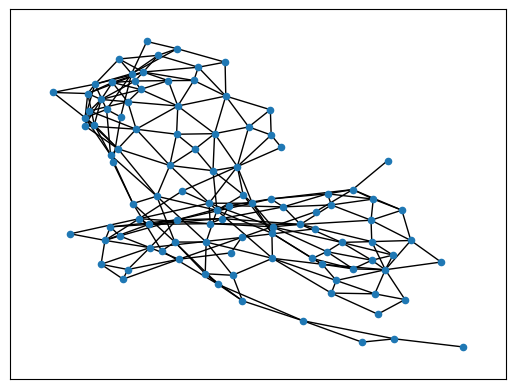

In [4]:
edges = show_graph_with_labels(adjanceny_matrix_zeroed.values, adjanceny_matrix_zeroed.columns.tolist())

In [5]:
# Creating the adjacenjy matrix
import shapefile
import itertools
import os
#from haversine import haversine

myshp = open(os.path.join(os.getcwd(),"./Data/shapefiles/Distribution/Areas.shp"), "rb")
mydbf = open(os.path.join(os.getcwd(),"./Data/shapefiles/Distribution/Areas.dbf"), "rb")
myshx= open(os.path.join(os.getcwd(),"./Data/shapefiles/Distribution/Areas.shx"), "rb")

r = shapefile.Reader(shp=myshp, dbf=mydbf, shx=myshx)

# Getting postcode midpoints
fields = r.records()
fields = [x[0] for x in fields]

# Getting shapes
shapes = r.shapes()

# Compiling into dictionary
data = {keys:values for (keys,values) in zip(fields,shapes)}

In [6]:
import numpy as np

def polygon_area(xs, ys):
    """https://en.wikipedia.org/wiki/Centroid#Of_a_polygon"""
    # https://stackoverflow.com/a/30408825/7128154
    return 0.5 * (np.dot(xs, np.roll(ys, 1)) - np.dot(ys, np.roll(xs, 1)))

def polygon_centroid(xs, ys):
    """https://en.wikipedia.org/wiki/Centroid#Of_a_polygon"""
    xy = np.array([xs, ys])
    c = np.dot(xy + np.roll(xy, 1, axis=1),
               xs * np.roll(ys, 1) - np.roll(xs, 1) * ys
               ) / (6 * polygon_area(xs, ys))
    return c

import tqdm
import time
centroids = dict()
for PA,shp in tqdm.tqdm(data.items()):
    time.sleep(0.1)
    xs = list()
    ys = list()
    for x,y in shp.points:
        xs.append(x)
        ys.append(y)
    
    x_mean = sum(xs)/len(xs)
    y_mean = sum(ys)/len(ys)
    centroids[PA] = (x_mean,y_mean)

centroids

100%|██████████| 124/124 [00:13<00:00,  9.05it/s]


{'AB': (-2.201381727378353, 57.4385880260874),
 'AL': (-0.2936788542179847, 51.78175940943029),
 'B': (-1.8965001642503607, 52.46173014052012),
 'BA': (-2.462131258556518, 51.160700530010125),
 'BB': (-2.3402396114186037, 53.789158546932256),
 'BD': (-1.8655687001258248, 53.851959798361676),
 'BH': (-1.9799203224204422, 50.68982660402734),
 'BL': (-2.3890333155651766, 53.576588943457196),
 'BN': (-0.06679069893395664, 50.82475917297892),
 'BR': (0.035044993443068294, 51.399746916060884),
 'BS': (-2.7337244260929143, 51.45397533494825),
 'CA': (-3.332902390256513, 54.71461913922518),
 'CB': (0.22606415496888127, 52.19374512326875),
 'CF': (-3.3751083975929372, 51.480802205032326),
 'CH': (-3.074866927419917, 53.3025264209351),
 'CM': (0.675314058273223, 51.72669674779797),
 'CO': (1.0478636383577415, 51.86976061193931),
 'CR': (-0.11316574513756003, 51.37314489423506),
 'CT': (1.2494208323761873, 51.240674242764605),
 'CV': (-1.515874019400739, 52.34106163609418),
 'CW': (-2.44956424538

In [7]:
new_centroids = dict()
for col in adjanceny_matrix_zeroed.columns:
    new_centroids[col] = centroids[col]

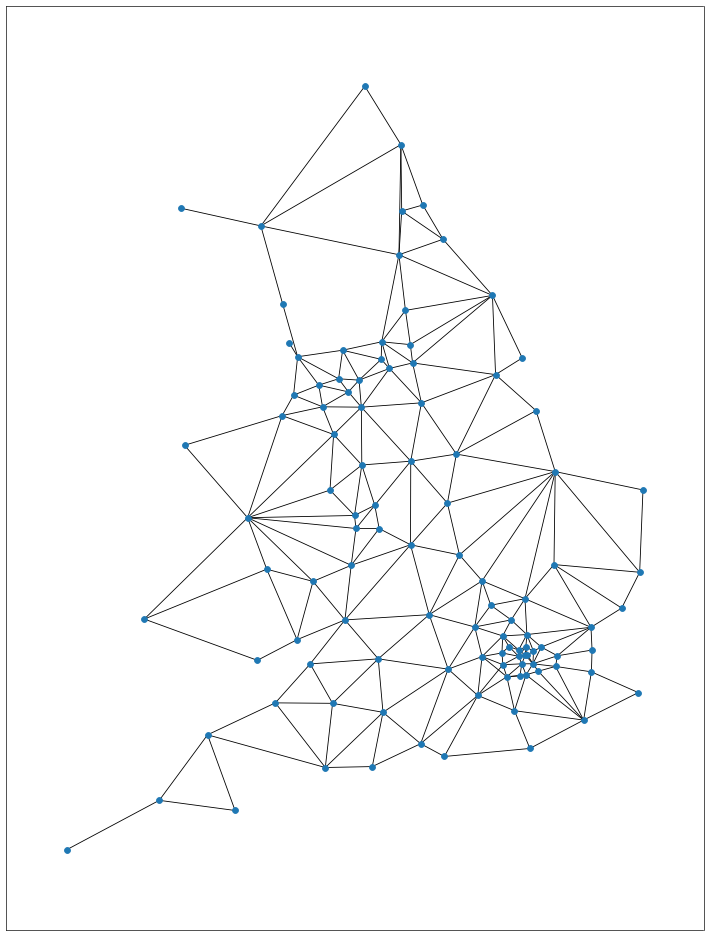

In [70]:
fig = plt.figure(1, figsize=(15, 20), dpi=60)
edges = show_graph_with_labels_points(adjanceny_matrix_zeroed.values, adjanceny_matrix_zeroed.columns.tolist(),list(new_centroids.values()))

# Simple Regression Model

First Approach is to fit a linear regression model for each Postcode Area.

In [1]:
# Very Basic Quarter Dummy Variable Model
from sklearn.linear_model import LinearRegression

import pandas as pd
import numpy as np
from matplotlib import pyplot as pyplot
import networkx as nx
import os

adjanceny_matrix = pd.read_csv(os.path.join(os.getcwd(),'./Data/adjacency_matrix_1km.csv'),index_col=0)
growth_df = pd.read_csv(os.path.join(os.getcwd(),'./Data/quarter_aggs_growth.csv'),parse_dates=['transaction_quarter'])[1:]

# Deleting these postcode areas as they are sparse
growth_df = growth_df.drop(columns=['DG','LR','SU','UNKN']).dropna()
print(growth_df.shape)
postcode_areas = [x for x in growth_df.columns if x not in ['transaction_quarter']]
growth_df['quarter'] = growth_df['transaction_quarter'].dt.quarter
growth_df.head()

(112, 106)


,transaction_quarter,AL,B,BA,BB,BD,BH,BL,BN,BR,...,WA,WC,WD,WF,WN,WR,WS,WV,YO,quarter
1,1995-06-30,0.019926,-0.005003,0.038441,0.046111,0.024650,0.052442,0.040700,0.041553,0.062290,...,0.012326,-0.142877,-0.005684,0.015257,0.001528,0.058039,0.054927,0.032791,0.011766,2
2,1995-09-30,0.080796,0.031458,0.007169,-0.004036,0.010962,0.007171,-0.050768,0.006139,-0.021335,...,0.025291,0.134695,0.042685,0.017661,0.022163,0.035859,0.005173,0.021138,0.041306,3
3,1995-12-31,-0.052187,-0.023593,-0.036614,-0.016223,-0.004611,-0.041393,0.040855,-0.009102,0.026384,...,-0.037250,0.190908,-0.036660,-0.012971,-0.018206,-0.016764,0.027097,-0.052739,-0.016435,4
4,1996-03-31,0.000837,-0.056534,-0.013560,-0.050434,-0.042732,0.004152,-0.066548,-0.018821,-0.016857,...,-0.022584,-0.349223,-0.038262,-0.018427,-0.019089,-0.038293,-0.058791,-0.033309,-0.020376,1
5,1996-06-30,0.052270,0.092336,0.070256,0.047689,0.090793,0.030651,0.050527,0.035019,0.049214,...,0.009211,0.315304,0.024001,0.058249,0.026345,0.036820,0.025697,0.072569,0.016316,2


<AxesSubplot: title={'center': 'growth'}, xlabel='quarter'>

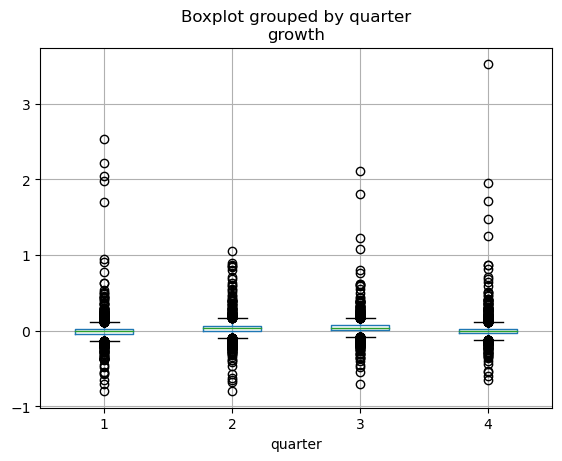

In [2]:
from sklearn.linear_model import LinearRegression

growth_df.drop(columns=['transaction_quarter']).set_index('quarter').stack().reset_index(level=1,
                                            drop=True).to_frame(name='growth').reset_index().boxplot(by='quarter',column='growth')

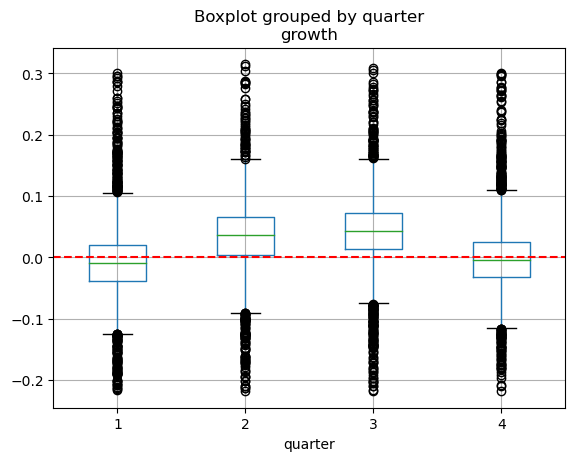

In [3]:
from matplotlib import pyplot as plt
quarter_growth_df = growth_df.drop(columns=['transaction_quarter']).set_index('quarter').stack().reset_index(level=1,
                                            drop=True).to_frame(name='growth').reset_index()
quarter_growth_df[(quarter_growth_df.growth<quarter_growth_df.growth.quantile(0.99))&\
                  (quarter_growth_df.growth>quarter_growth_df.growth.quantile(0.01))].boxplot(by='quarter',column='growth')
plt.axhline(0,c='r',ls='--')
plt.show()

In [7]:
train_df = growth_df.sample(frac=0.7,random_state=34)
test_df = growth_df[~growth_df.index.isin(train_df.index)]

#train_index = train_df[['transaction_date','']
#test_inde = test_df.index

print('train_df shape: ',train_df.shape)
print('test_df shape: ',test_df.shape)

train_df['quarter'] = train_df['quarter'].astype('category')
test_df['quarter'] = test_df['quarter'].astype('category')
train_quarters = train_df.transaction_quarter.astype(str).tolist()
test_quarters = test_df.transaction_quarter.astype(str).tolist()
train_df = train_df.drop(columns=['transaction_quarter']).set_index('quarter').stack().to_frame(name='growth').reset_index(level=1,drop=True).reset_index()
test_df = test_df.drop(columns=['transaction_quarter']).set_index('quarter').stack().to_frame(name='growth').reset_index(level=1,drop=True).reset_index()

print('train_df shape: ',train_df.shape)
print('test_df shape: ',test_df.shape)

train_df shape:  (78, 107)
test_df shape:  (34, 107)
train_df shape:  (8190, 2)
test_df shape:  (3570, 2)


C:\Users\cemly\AppData\Local\Temp\ipykernel_18652\1765684559.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['quarter'] = test_df['quarter'].astype('category')


In [8]:
from patsy import dmatrices, dmatrix, demo_data
from sklearn.linear_model import LinearRegression,Ridge

y_train,X_train =  dmatrices("growth ~ quarter", train_df)
y_test,X_test =  dmatrices("growth ~ quarter", test_df)

reg = LinearRegression(fit_intercept=False)
reg.fit(X_train,y_train)

from sklearn.metrics import mean_squared_error as mse

train_mse = mse(y_train,reg.predict(X_train))
test_mse = mse(reg.predict(X_test),y_test)

print('train mse:',train_mse)
print('test mse:',test_mse)

train mse: 0.012487868164266882
test mse: 0.01169643034252159


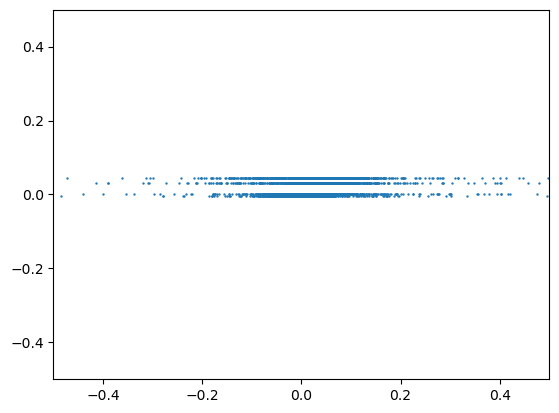

In [9]:
plt.scatter(y_test,reg.predict(X_test),s=0.5)
plt.xlim(-0.5,0.5)
plt.ylim(-0.5,0.5)
plt.show()

Now adding the previous quarters performance.

In [354]:
def process(df):
    aggs = df.set_index('transaction_quarter').drop(columns=['quarter']).stack().sort_index(level=[1,0]).to_frame(name='growth')
    aggs['prev_growth'] = aggs.groupby(level=1).shift(1)
    aggs = aggs.reset_index(level=1,drop=True).reset_index()
    aggs['quarter'] = aggs['transaction_quarter'].dt.quarter
    aggs['quarter'] = aggs['quarter'].astype('category')
    aggs['transaction_quarter'] = aggs['transaction_quarter'].astype(str)
    aggs = aggs.set_index('transaction_quarter')
    aggs = aggs.dropna()
    return aggs

# train_df = process(train_df)
# test_df = process(test_df)

growth_df_processed = process(growth_df)

train_df = growth_df_processed[growth_df_processed.index.isin(train_quarters)]
test_df = growth_df_processed[growth_df_processed.index.isin(test_quarters)]

print('train_df shape: ',train_df.shape)
print('test_df shape: ',test_df.shape)

print('train_df dtypes',train_df.dtypes)
print('test_df dtypes',test_df.dtypes)

train_df shape:  (8085, 3)
test_df shape:  (3570, 3)
train_df dtypes growth          float64
prev_growth     float64
quarter        category
dtype: object
test_df dtypes growth          float64
prev_growth     float64
quarter        category
dtype: object


In [357]:
from patsy import dmatrices, dmatrix, demo_data
from sklearn.linear_model import LinearRegression,Ridge,HuberRegressor
from sklearn.model_selection import train_test_split

#y,X =  dmatrices("growth ~ prev_growth + quarter", growth_df_processed)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=4000)

y_train,X_train = dmatrices("growth ~ prev_growth + quarter", train_df)
y_test,X_test = dmatrices("growth ~ prev_growth + quarter", test_df)

print('train_df shape: ',X_train.shape)
print('test_df shape: ',X_test.shape)

reg = Ridge(fit_intercept=False,alpha=1.0)
#reg = HuberRegressor(fit_intercept=False)
reg.fit(X_train,y_train)

from sklearn.metrics import mean_squared_error as mse

train_mse2 = mse(y_train,reg.predict(X_train))
test_mse2 = mse(reg.predict(X_test),y_test)

print('train mse:',train_mse2)
print('test mse:',test_mse2)

train_df shape:  (8085, 5)
test_df shape:  (3570, 5)
train mse: 0.011415245277255676
test mse: 0.009931812063214173


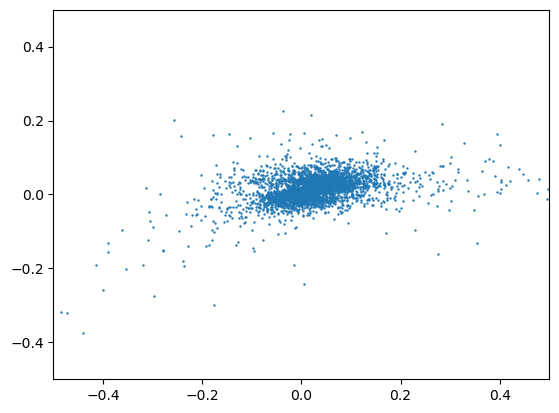

In [356]:
plt.scatter(y_test,reg.predict(X_test),s=0.5)
plt.xlim(-0.5,0.5)
plt.ylim(-0.5,0.5)
plt.show()

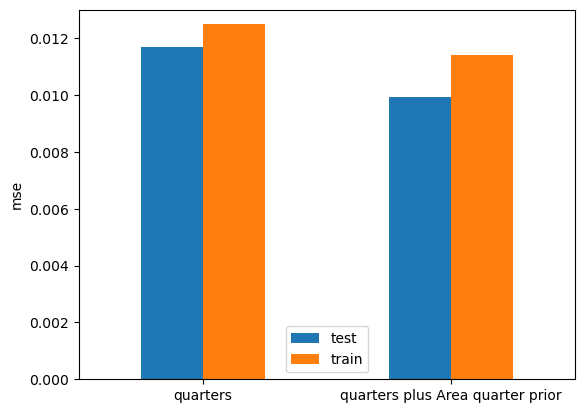

In [13]:
perf = pd.DataFrame({"test":[test_mse,test_mse2],
        "train":[train_mse,train_mse2]},
        index=['quarters','quarters plus Area quarter prior'])
perf.plot.bar()
plt.ylim(0.000,0.013)
plt.ylabel('mse')
plt.xticks(rotation=0)
plt.show()

In [375]:
def process2(df):
    aggs = df.set_index('transaction_quarter').drop(columns=['quarter']).stack().sort_index(level=[1,0]).to_frame(name='growth')
    aggs['prev_growth'] = aggs.groupby(level=1).shift(1)
    aggs = aggs.reset_index(level=0)
    aggs['quarter'] = aggs['transaction_quarter'].dt.quarter.astype('str')
    aggs['transaction_quarter'] = aggs['transaction_quarter'].astype(str)
    aggs = aggs.reset_index()
    aggs = aggs.rename(columns={'index':'postArea'})
    aggs = aggs.set_index(['transaction_quarter','postArea'])
    # aggs = aggs.dropna()
    return aggs

growth_df_processed = process2(growth_df)
growth_df_processed.head()

,,growth,prev_growth,quarter
transaction_quarter,postArea,,,
1995-06-30,AL,0.019926,NaN,2
1995-09-30,AL,0.080796,0.019926,3
1995-12-31,AL,-0.052187,0.080796,4
1996-03-31,AL,0.000837,-0.052187,1
1996-06-30,AL,0.052270,0.000837,2


In [350]:
# Per area regression
import tqdm

reg_dict = dict()
train_predictions_lst = list()
test_predictions_lst = list()
y_train_lst = list()
y_test_lst = list()

for pa in tqdm.tqdm(growth_df_processed.reset_index()['postArea'].unique()):
    reg_dict[pa] = LinearRegression()
    area_df = growth_df_processed.query(f'postArea=="{pa}"').reset_index(level=1,drop=True)[1:]

    train_area_df = area_df[area_df.index.isin(train_quarters)]
    test_area_df = area_df[area_df.index.isin(test_quarters)]

    y_train,X_train = dmatrices("growth ~ prev_growth + quarter", train_area_df)
    y_test,X_test = dmatrices("growth ~ prev_growth + quarter", test_area_df)

    reg_dict[pa].fit(X_train,y_train)
    train_predictions = reg_dict[pa].predict(X_train)
    test_predictions = reg_dict[pa].predict(X_test)

    train_predictions_lst.append(train_predictions)
    test_predictions_lst.append(test_predictions)

    y_train_lst.append(y_train)
    y_test_lst.append(y_test)

train_predictions = np.concatenate(train_predictions_lst)
test_predictions = np.concatenate(test_predictions_lst)

y_train = np.concatenate(y_train_lst)
y_test = np.concatenate(y_test_lst)

print('y_train shape: ',y_train.shape)
print('y_test shape: ',y_test.shape)

100%|██████████| 105/105 [00:01<00:00, 84.95it/s]

y_train shape:  (8085, 1)
y_test shape:  (3570, 1)


In [351]:
train_mse3 = mse(y_train,train_predictions)
test_mse3 = mse(y_test,test_predictions)

print('train mse:',train_mse3)
print('test mse:',test_mse3)

train mse: 0.010452864947441217
test mse: 0.01039188381854326


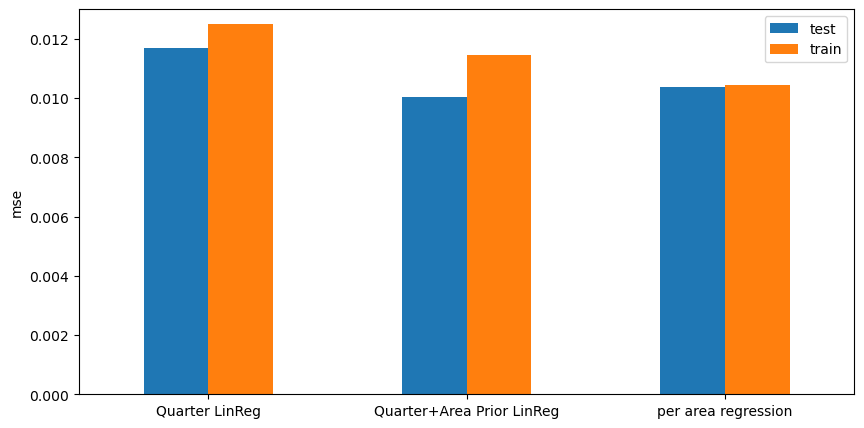

In [360]:
perf = pd.DataFrame({"test":[test_mse,test_mse2,test_mse3],
        "train":[train_mse,train_mse2,train_mse3]},
        index=['Quarter LinReg','Quarter+Area Prior LinReg','per area regression'])
perf.plot.bar(figsize=[10,5])
plt.ylim(0.000,0.013)
plt.ylabel('mse')
plt.xticks(rotation=0)
plt.show()

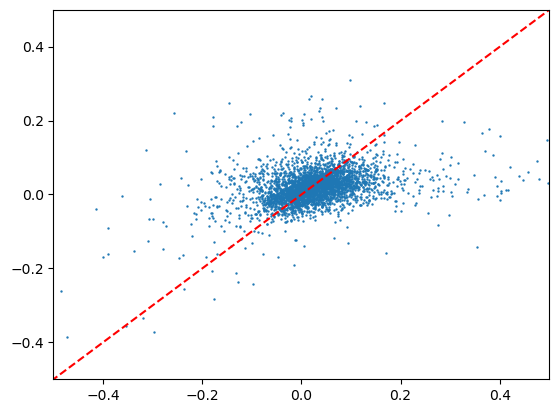

In [361]:
plt.scatter(y_test,test_predictions,s=0.5)
plt.plot(np.arange(-0.6,0.6,0.1),np.arange(-0.6,0.6,0.1),c='r',ls='--')
plt.xlim(-0.5,0.5)
plt.ylim(-0.5,0.5)
plt.show()

Now creating a fully connected Neural Network model.

In [362]:
growth_df_train = growth_df[growth_df.transaction_quarter.isin(train_quarters)].drop(columns=['transaction_quarter'])
growth_df_test = growth_df[growth_df.transaction_quarter.isin(test_quarters)].drop(columns=['transaction_quarter'])
growth_df_train

,AL,B,BA,BB,BD,BH,BL,BN,BR,BS,...,WA,WC,WD,WF,WN,WR,WS,WV,YO,quarter
1,0.019926,-0.005003,0.038441,0.046111,0.024650,0.052442,0.040700,0.041553,0.062290,0.016477,...,0.012326,-0.142877,-0.005684,0.015257,0.001528,0.058039,0.054927,0.032791,0.011766,2
2,0.080796,0.031458,0.007169,-0.004036,0.010962,0.007171,-0.050768,0.006139,-0.021335,0.052567,...,0.025291,0.134695,0.042685,0.017661,0.022163,0.035859,0.005173,0.021138,0.041306,3
4,0.000837,-0.056534,-0.013560,-0.050434,-0.042732,0.004152,-0.066548,-0.018821,-0.016857,-0.019387,...,-0.022584,-0.349223,-0.038262,-0.018427,-0.019089,-0.038293,-0.058791,-0.033309,-0.020376,1
5,0.052270,0.092336,0.070256,0.047689,0.090793,0.030651,0.050527,0.035019,0.049214,0.060323,...,0.009211,0.315304,0.024001,0.058249,0.026345,0.036820,0.025697,0.072569,0.016316,2
7,-0.017297,0.018409,-0.020851,0.003726,0.016468,-0.013932,-0.001219,0.011439,-0.002291,-0.013995,...,-0.004549,0.132173,-0.085764,0.052014,0.026965,-0.034148,0.020303,0.015324,0.003849,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105,-0.005456,0.010233,-0.037047,0.192936,0.041080,0.001239,0.051079,-0.000952,0.034789,0.034037,...,0.054437,-0.800793,0.006072,0.182683,0.285265,0.011133,-0.037581,0.007120,-0.030930,2
108,-0.091499,-0.012576,0.048810,0.042666,0.065537,0.057100,0.216819,0.037891,0.088420,0.151683,...,-0.009775,0.364524,-0.017707,-0.019649,-0.125984,-0.021964,-0.113218,-0.033825,-0.058389,1
110,0.111459,0.053703,0.032157,0.157416,0.017882,0.028513,-0.119200,0.097327,-0.009712,0.006867,...,0.047908,-0.038637,-0.039014,0.031629,-0.140818,0.071938,-0.003058,0.097240,0.007608,3
111,-0.050738,-0.042665,-0.029026,-0.129461,-0.020204,-0.012634,0.036943,-0.023483,-0.008060,0.023132,...,0.003151,-0.653178,-0.075820,0.253469,0.013455,-0.007280,0.029859,-0.018720,0.022537,4


In [363]:
def process3(df_):
    df = df_.copy()
    quarters = df[['quarter']]
    df0 = df.drop(columns=['quarter']).shift(1)
    X = pd.concat([df0,quarters],axis=1)[1:]
    X = pd.get_dummies(X,columns=['quarter'])
    y = df[1:].drop(columns=['quarter'])
    return X,y

X_train,y_train = process3(growth_df_train)
X_test,y_test = process3(growth_df_test)
X_train.head()

,AL,B,BA,BB,BD,BH,BL,BN,BR,BS,...,WF,WN,WR,WS,WV,YO,quarter_1,quarter_2,quarter_3,quarter_4
2,0.019926,-0.005003,0.038441,0.046111,0.024650,0.052442,0.040700,0.041553,0.062290,0.016477,...,0.015257,0.001528,0.058039,0.054927,0.032791,0.011766,0,0,1,0
4,0.080796,0.031458,0.007169,-0.004036,0.010962,0.007171,-0.050768,0.006139,-0.021335,0.052567,...,0.017661,0.022163,0.035859,0.005173,0.021138,0.041306,1,0,0,0
5,0.000837,-0.056534,-0.013560,-0.050434,-0.042732,0.004152,-0.066548,-0.018821,-0.016857,-0.019387,...,-0.018427,-0.019089,-0.038293,-0.058791,-0.033309,-0.020376,0,1,0,0
7,0.052270,0.092336,0.070256,0.047689,0.090793,0.030651,0.050527,0.035019,0.049214,0.060323,...,0.058249,0.026345,0.036820,0.025697,0.072569,0.016316,0,0,0,1
8,-0.017297,0.018409,-0.020851,0.003726,0.016468,-0.013932,-0.001219,0.011439,-0.002291,-0.013995,...,0.052014,0.026965,-0.034148,0.020303,0.015324,0.003849,1,0,0,0


In [364]:
print(y_train.shape)

(77, 105)


In [365]:
import tensorflow as tf
import pandas as pd
from tensorflow import keras

In [366]:
from tensorflow import keras

model = keras.Sequential(
    [
        keras.layers.Dense(
            y_train.shape[-1], activation="relu", input_shape=(X_train.shape[-1],)
        ),
        keras.layers.Dense(y_train.shape[-1]//2, activation="relu"),
        #eras.layers.Dropout(0.3),
        keras.layers.Dense(y_train.shape[-1], activation=None),
    ]
)
model.summary()

Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_78 (Dense)            (None, 105)               11550     
                                                                 
 dense_79 (Dense)            (None, 52)                5512      
                                                                 
 dense_80 (Dense)            (None, 105)               5565      
                                                                 
Total params: 22,627
Trainable params: 22,627
Non-trainable params: 0
_________________________________________________________________


In [367]:
model.compile(
    optimizer=keras.optimizers.Adam(1e-3), loss="mean_squared_error"
)

my_callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=10),
    tf.keras.callbacks.ModelCheckpoint(filepath='model.{epoch:02d}-{val_loss:.2f}.h5',save_best_only=True, monitor='val_loss', mode='min'),
    tf.keras.callbacks.TensorBoard(log_dir='./logs'),
]

history = model.fit(
    X_train,
    y_train,
    batch_size=10,
    epochs=5,
    verbose=2,
    validation_data=(X_test, y_test),
    callbacks=my_callbacks
)


Epoch 1/5
8/8 - 1s - loss: 0.0157 - val_loss: 0.0139 - 610ms/epoch - 76ms/step
Epoch 2/5
8/8 - 0s - loss: 0.0137 - val_loss: 0.0133 - 177ms/epoch - 22ms/step
Epoch 3/5
8/8 - 0s - loss: 0.0130 - val_loss: 0.0130 - 155ms/epoch - 19ms/step
Epoch 4/5
8/8 - 0s - loss: 0.0126 - val_loss: 0.0129 - 128ms/epoch - 16ms/step
Epoch 5/5
8/8 - 0s - loss: 0.0123 - val_loss: 0.0129 - 113ms/epoch - 14ms/step


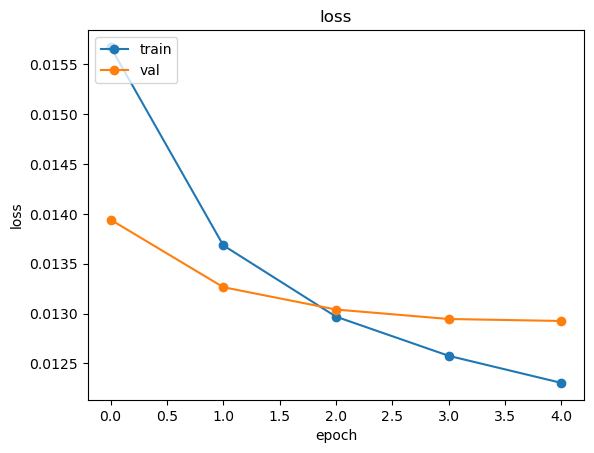

In [368]:
import keras
from matplotlib import pyplot as plt
plt.plot(history.history['loss'],marker='o')
plt.plot(history.history['val_loss'],marker='o')
plt.title('loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
#plt.yscale('log')
plt.show()

In [369]:
test_predictions = model.predict(X_test).ravel()
train_predictions = model.predict(X_train).ravel()

3/3 [==============================] - 0s 3ms/step


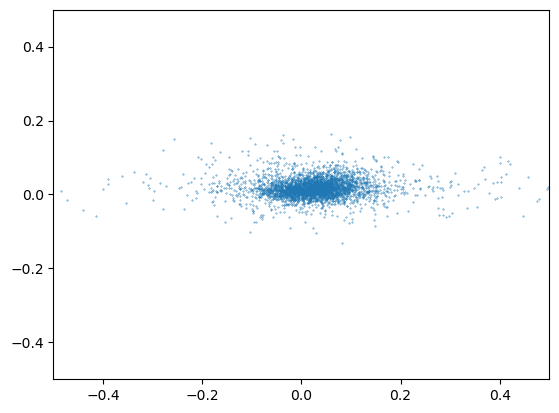

In [370]:
plt.scatter(y_test.values.ravel(),test_predictions.ravel(),s=0.1)
plt.xlim(-0.5,0.5)
plt.ylim(-0.5,0.5)
plt.show()

In [371]:
train_mse4 = mse(y_train.values.ravel(),train_predictions)
test_mse4 = mse(y_test.values.ravel(),test_predictions)

print('train mse:',train_mse4)
print('test mse:',test_mse4)

train mse: 0.01212616578592521
test mse: 0.012926325608189527


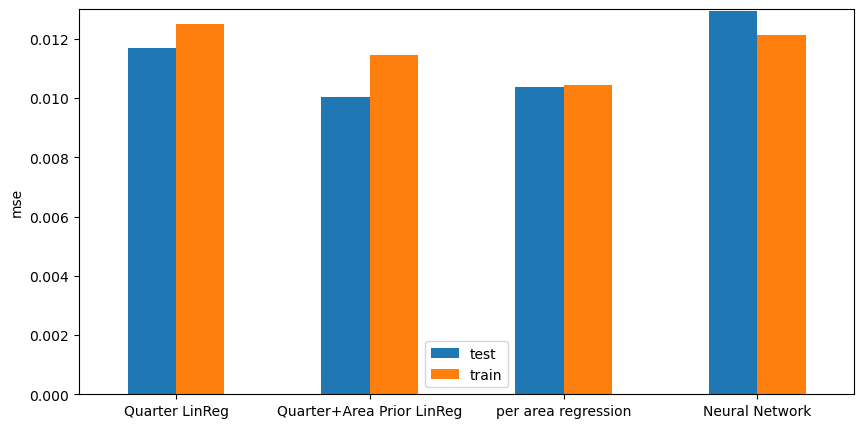

In [372]:
perf = pd.DataFrame({"test":[test_mse,test_mse2,test_mse3,test_mse4],
        "train":[train_mse,train_mse2,train_mse3,train_mse4]},
        index=['Quarter LinReg','Quarter+Area Prior LinReg','per area regression','Neural Network'])
perf.plot.bar(figsize=[10,5])
plt.ylim(0.000,0.013)
plt.ylabel('mse')
plt.xticks(rotation=0)
plt.show()

Regression using nearest nodes.

In [382]:
# Per area regression
import tqdm

reg_dict = dict()
train_predictions_lst = list()
test_predictions_lst = list()
y_train_lst = list()
y_test_lst = list()

for pa in tqdm.tqdm(growth_df_processed.reset_index()['postArea'].unique()):

    reg_dict[pa] = LinearRegression()
    reg_dict[pa] = HuberRegressor()

    adjanceny_matrix = pd.read_csv(os.path.join(os.getcwd(),'./Data/adjacency_matrix_1km.csv'),index_col=0)
    adjancent_index = adjanceny_matrix.loc[pa]
    adjancent_postcodes = adjancent_index[adjancent_index>0].index.tolist()
    query_string = 'postArea in '+str(adjancent_postcodes)

    area_df = growth_df_processed.query(query_string)
    y_df = area_df.drop(columns='quarter').unstack()[('growth',pa)].to_frame(name='growth')

    X_df = area_df.drop(columns='quarter').unstack()[('prev_growth')]

    new_df = pd.concat([y_df,X_df],axis=1)[1:]
    new_df['quarter'] = new_df.index
    new_df['quarter'] = pd.to_datetime(new_df['quarter']).dt.quarter.astype(str)
    train_area_df = new_df[new_df.index.isin(train_quarters)]
    test_area_df = new_df[new_df.index.isin(test_quarters)]

    postcodes =  [x for x in train_area_df if x not in ['growth','quarter','prev_growth'] ]
    pasty_string = "growth ~ quarter +" + "+".join(postcodes)

    y_train,X_train = dmatrices(pasty_string, train_area_df)
    y_test,X_test = dmatrices(pasty_string, test_area_df)

    reg_dict[pa].fit(X_train,y_train)
    train_predictions = reg_dict[pa].predict(X_train)
    test_predictions = reg_dict[pa].predict(X_test)

    train_predictions_lst.append(train_predictions)
    test_predictions_lst.append(test_predictions)

    y_train_lst.append(y_train)
    y_test_lst.append(y_test)

train_predictions = np.concatenate(train_predictions_lst)
test_predictions = np.concatenate(test_predictions_lst)

y_train = np.concatenate(y_train_lst)
y_test = np.concatenate(y_test_lst)

print('y_train shape: ',y_train.shape)
print('y_test shape: ',y_test.shape)

  0%|          | 0/105 [00:00<?, ?it/s]c:\Users\cemly\anaconda3\envs\tf_env\lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\cemly\anaconda3\envs\tf_env\lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\cemly\anaconda3\envs\tf_env\lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
  3%|▎         | 3/105 [00:00<00:05, 19.86it/s]c:\Users\cemly\anaconda3\envs\tf_env\lib\site-packages\sklearn\utils\validation.

y_train shape:  (8085, 1)
y_test shape:  (3570, 1)


In [383]:
train_mse5 = mse(y_train,train_predictions)
test_mse5 = mse(y_test,test_predictions)

print('train mse:',train_mse5)
print('test mse:',test_mse5)

train mse: 0.00996393457091164
test mse: 0.011063178049816654


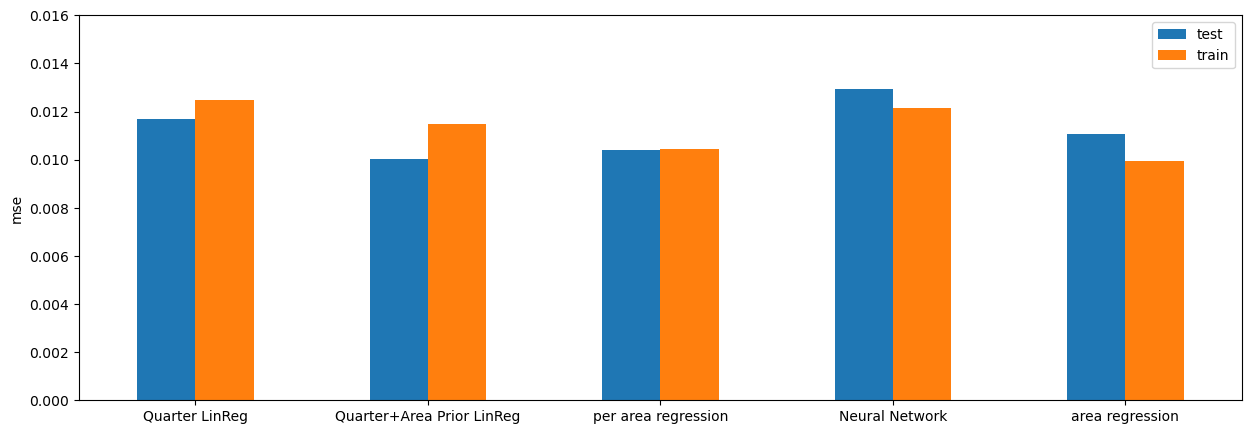

In [384]:
perf = pd.DataFrame({"test":[test_mse,test_mse2,test_mse3,test_mse4,test_mse5],
        "train":[train_mse,train_mse2,train_mse3,train_mse4,train_mse5]},
        index=['Quarter LinReg','Quarter+Area Prior LinReg','per area regression','Neural Network','area regression'])
perf.plot.bar(figsize=[15,5])
plt.ylim(0.000,0.016)
plt.ylabel('mse')
plt.xticks(rotation=0)
plt.show()

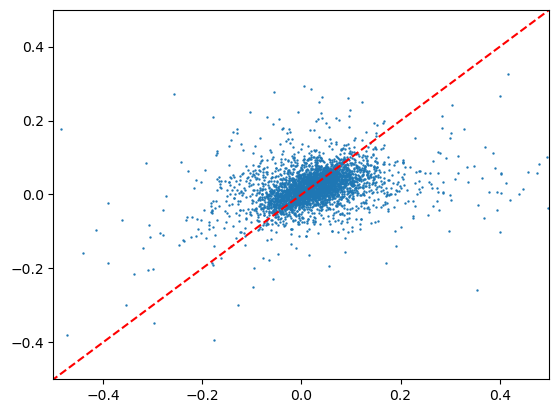

In [385]:
plt.scatter(y_test,test_predictions,s=0.5)
plt.plot(np.arange(-0.6,0.6,0.1),np.arange(-0.6,0.6,0.1),c='r',ls='--')
plt.xlim(-0.5,0.5)
plt.ylim(-0.5,0.5)
plt.show()